In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("sales_5000000.csv")
df = df[['Order Date', 'Total Profit']] 
df['Order Date'] = pd.to_datetime(df['Order Date'])
daily_df = df.groupby('Order Date')['Total Profit'].sum().reset_index()
monthly_df = daily_df.resample('ME', on='Order Date')['Total Profit'].sum().reset_index()
monthly_df.columns = ['Order Date', 'Total Profit']
monthly_df.set_index('Order Date', inplace=True)

In [3]:
monthly_df

,Total Profit
Order Date,
2014-01-31,1.556656e+10
2014-02-28,1.402973e+10
2014-03-31,1.556248e+10
2014-04-30,1.510544e+10
2014-05-31,1.559264e+10
...,...
2024-05-31,1.558589e+10
2024-06-30,1.506300e+10
2024-07-31,1.553073e+10


<Axes: >

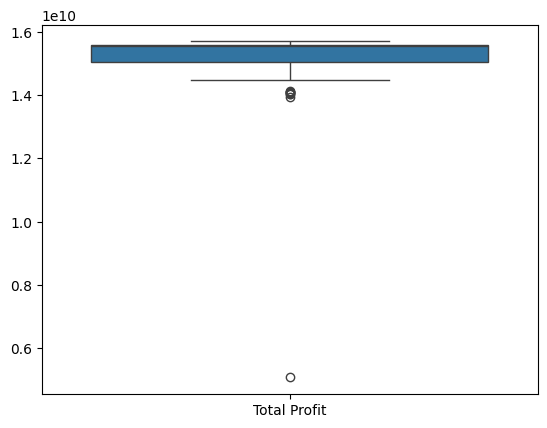

In [4]:
sns.boxplot(monthly_df)

In [5]:
Q1 = monthly_df['Total Profit'].quantile(0.25)
Q3 = monthly_df['Total Profit'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
monthly_df = monthly_df[(monthly_df['Total Profit'] >= lower_bound) & 
                      (monthly_df['Total Profit'] <= upper_bound)]

<Axes: >

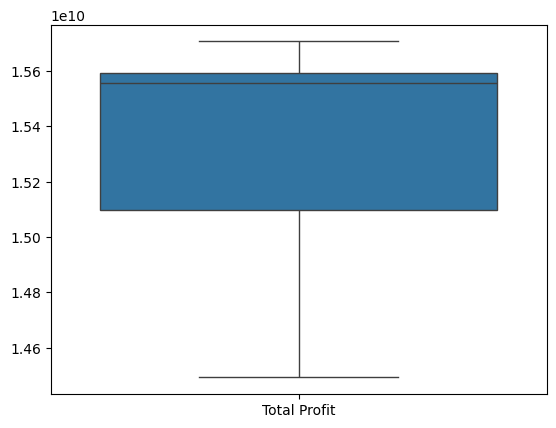

In [6]:
sns.boxplot(monthly_df)

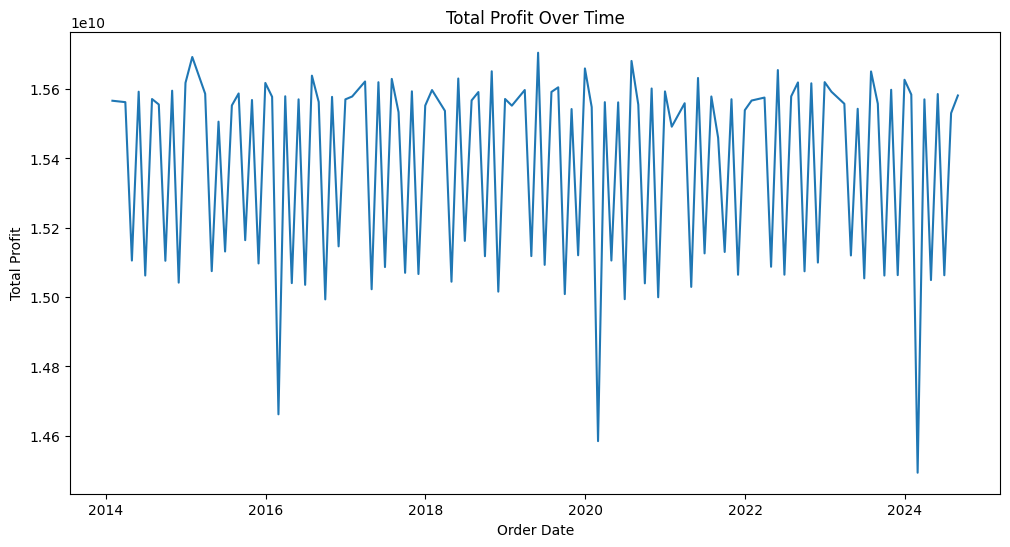

In [7]:
plt.figure(figsize=(12,6))
plt.plot(monthly_df)
plt.xlabel('Order Date')
plt.ylabel('Total Profit')
plt.title('Total Profit Over Time')
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, series is stationary")
    else:
        print("Weak evidence against null hypothesis, series is non-stationary")

print("ADF Test for Original Series:")
adf_test(monthly_df['Total Profit'])

ADF Test for Original Series:
ADF Statistic: -3.812401142617044
p-value: 0.0027829532555070963
Critical Values:
   1%: -3.4912451337340342
   5%: -2.8881954545454547
   10%: -2.5809876033057852
Strong evidence against the null hypothesis, series is stationary


In [9]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series):
    result = kpss(series)
    print('KPSS Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[3].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, series is non-stationary")
    else:
        print("Weak evidence against null hypothesis, series is stationary")

print("\nKPSS Test for Original Series:")
kpss_test(monthly_df['Total Profit'])


KPSS Test for Original Series:
KPSS Statistic: 0.06258259222503064
p-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Weak evidence against null hypothesis, series is stationary


C:\Users\Sailesh\AppData\Local\Temp\ipykernel_22448\1343309825.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)


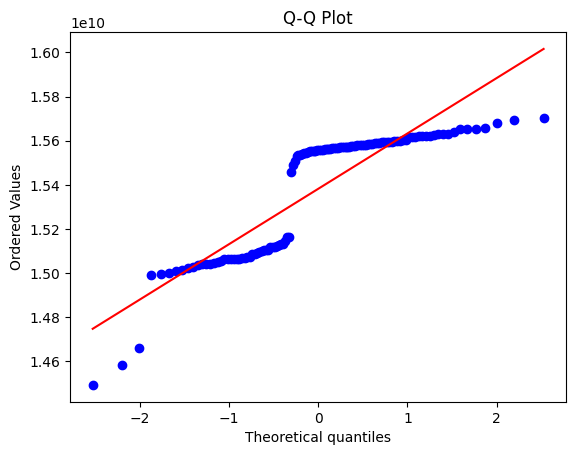

In [10]:
import scipy.stats as stats

stats.probplot(monthly_df['Total Profit'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

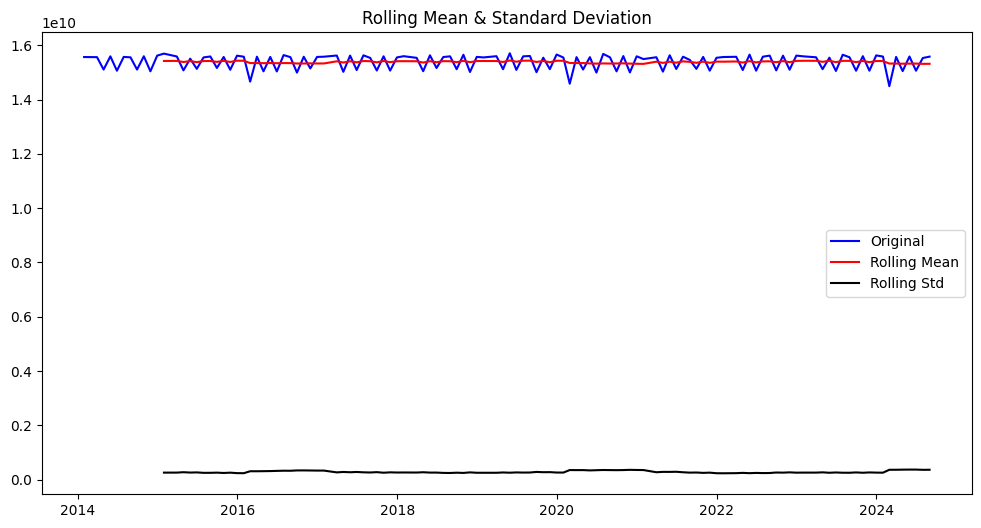

In [11]:
rolling_mean = monthly_df['Total Profit'].rolling(window=12).mean()
rolling_std = monthly_df['Total Profit'].rolling(window=12).std()

plt.figure(figsize=(12,6))
plt.plot(monthly_df['Total Profit'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

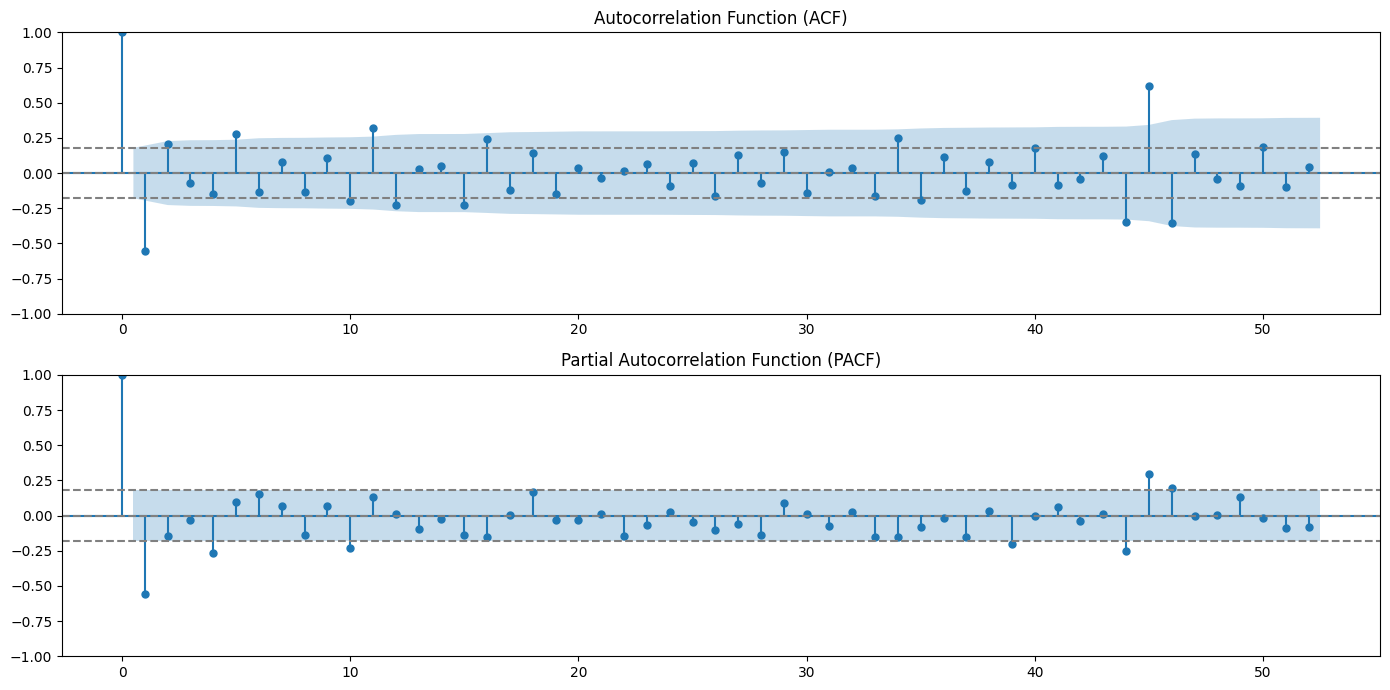

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plot_acf(monthly_df['Total Profit'], lags=52, ax=plt.gca(), 
         title='Autocorrelation Function (ACF)')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthly_df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthly_df)), linestyle='--', color='gray')

plt.subplot(2, 1, 2)
plot_pacf(monthly_df['Total Profit'], lags=52, ax=plt.gca(), 
          title='Partial Autocorrelation Function (PACF)', method='ywm')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthly_df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthly_df)), linestyle='--', color='gray')

plt.tight_layout()
plt.show()